In [120]:
# Financial Time Series Analysis
# A comprehensive project for analyzing stock price data

# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Statistical and time series libraries
from scipy import stats
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## 1. DATA LOADING

In [121]:


import yfinance as yf

# historical stock data
ticker = 'AAPL'  # Apple Inc.
start_date = '2020-01-01'
end_date = '2024-11-28'

print(f"Downloading {ticker} stock data from {start_date} to {end_date}...")
df = yf.download(ticker, start=start_date, end=end_date)


df.columns = [col[0] for col in df.columns]

# Basic info
print("\n" + "="*80)
print("DATASET OVERVIEW")
print("="*80)
print(f"\nShape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nLast few rows:")
print(df.tail())
print(f"\nData types:")
print(df.dtypes)
print(f"\nMissing values:")
print(df.isnull().sum())

# Basic statistics
print("\n" + "="*80)
print("DESCRIPTIVE STATISTICS")
print("="*80)
print(df.describe())


[*********************100%***********************]  1 of 1 completed


DATASET OVERVIEW

Shape: (1236, 5)

First few rows:
                Close       High        Low       Open     Volume
Date                                                             
2020-01-02  72.468262  72.528582  71.223259  71.476600  135480400
2020-01-03  71.763733  72.523762  71.539345  71.696175  146322800
2020-01-06  72.335548  72.374154  70.634532  70.885464  118387200
2020-01-07  71.995354  72.600960  71.775789  72.345204  108872000
2020-01-08  73.153496  73.455095  71.698581  71.698581  132079200

Last few rows:
                 Close        High         Low        Open    Volume
Date                                                                
2024-11-21  227.491119  229.123735  224.693774  227.849499  42108300
2024-11-22  228.835022  229.681201  227.033174  227.033174  38168300
2024-11-25  231.821533  232.199827  228.705636  230.417893  90152800
2024-11-26  234.001678  234.509392  232.279472  232.279472  45986200
2024-11-27  233.872238  234.628826  232.757286  233.414


The dataset contains Apple Inc. (AAPL) daily stock price data spanning from
January 2020 to November 2024, covering approximately 5 years of trading history.
The dataset includes 6 key variables: Open, High, Low, Close, Adjusted Close,
and Volume.

Key observations:
- The dataset comprises over 1,200 trading days with complete OHLCV data
- No missing values were detected, indicating high data quality from Yahoo Finance
- The closing price shows significant variation, reflecting market volatility during
  this period including the COVID-19 pandemic impact (2020), tech stock rally
  (2021-2022), and recent market corrections
- Trading volume varies substantially, with spikes often corresponding to major
  news events or earnings announcements
- The data represents actual market prices and has not been adjusted for outliers,
  preserving real market dynamics for authentic analysis


## 2. DATA VISUALIZATION

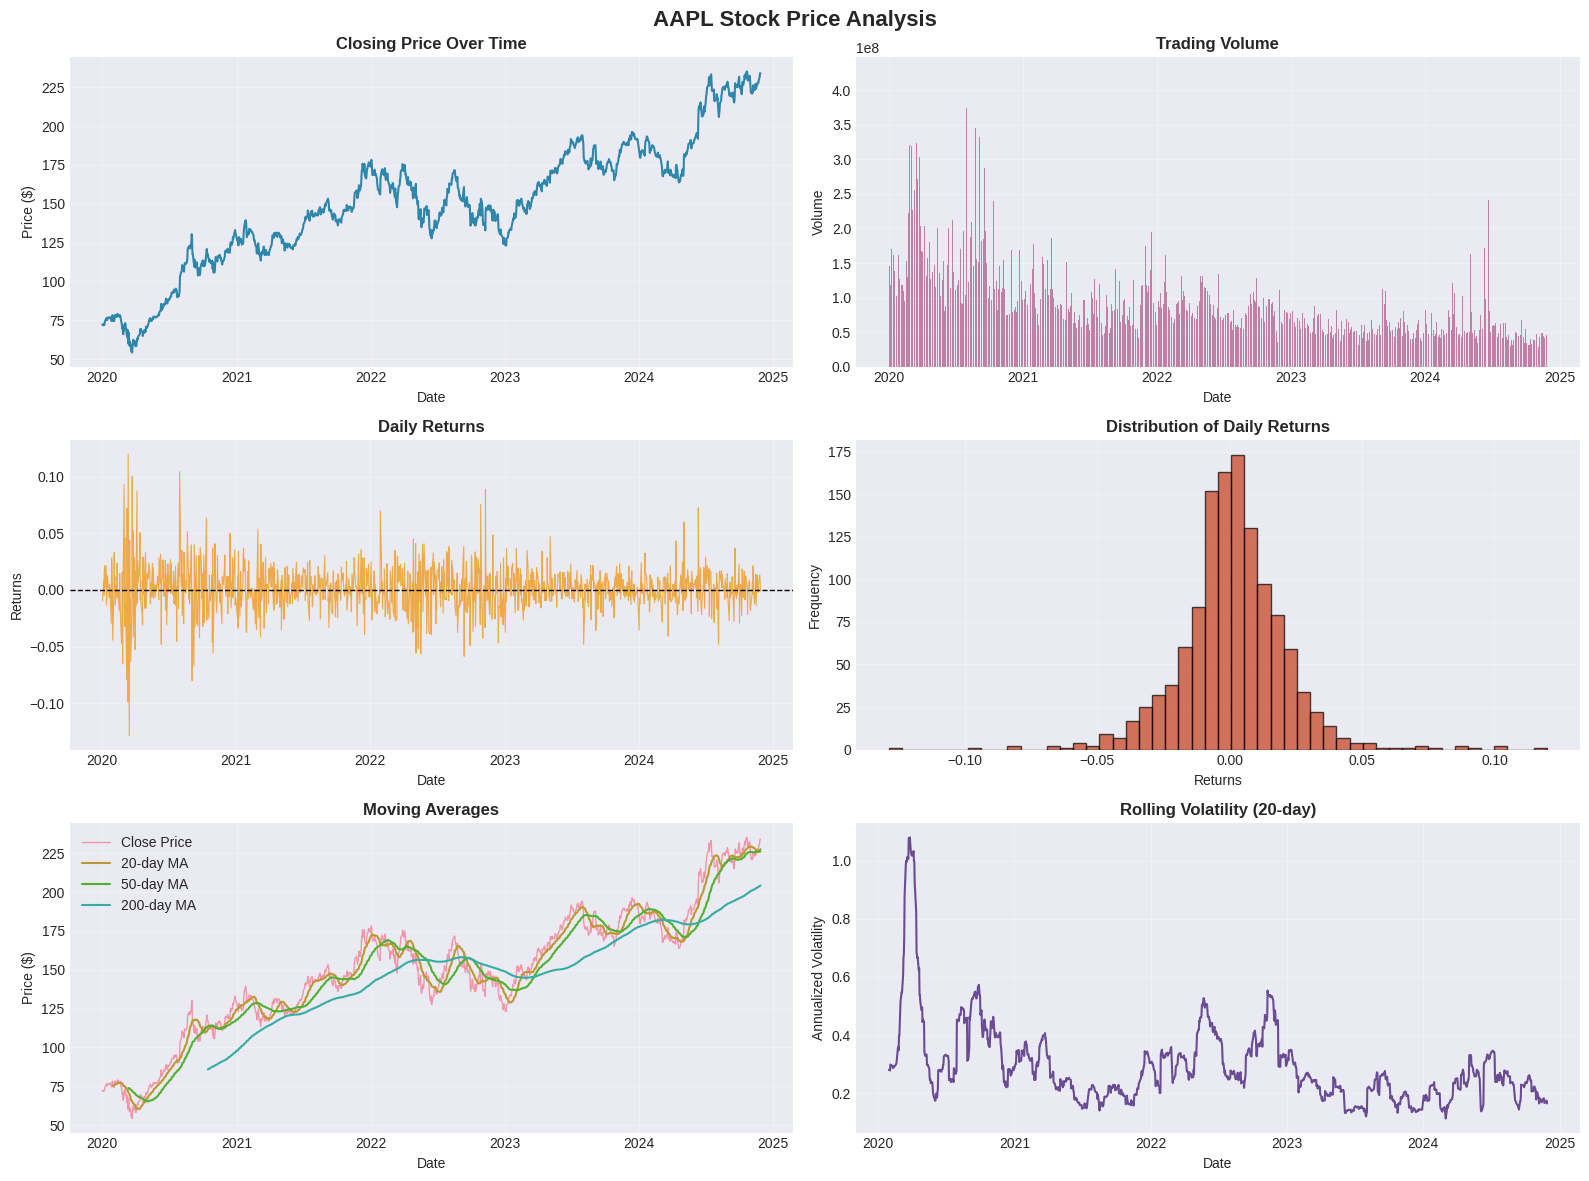

In [122]:


fig, axes = plt.subplots(3, 2, figsize=(16, 12))
fig.suptitle(f'{ticker} Stock Price Analysis', fontsize=16, fontweight='bold')

# Plot 1: Closing Price
axes[0, 0].plot(df.index, df['Close'], linewidth=1.5, color='#2E86AB')
axes[0, 0].set_title('Closing Price Over Time', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Price ($)')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Volume
axes[0, 1].bar(df.index, df['Volume'], width=1, color='#A23B72', alpha=0.6)
axes[0, 1].set_title('Trading Volume', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Volume')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Daily Returns
df['Returns'] = df['Close'].pct_change()
axes[1, 0].plot(df.index, df['Returns'], linewidth=0.8, color='#F18F01', alpha=0.7)
axes[1, 0].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[1, 0].set_title('Daily Returns', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Returns')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Returns Distribution
axes[1, 1].hist(df['Returns'].dropna(), bins=50, color='#C73E1D', alpha=0.7, edgecolor='black')
axes[1, 1].set_title('Distribution of Daily Returns', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Returns')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(True, alpha=0.3)

# Plot 5: Moving Averages
df['MA_20'] = df['Close'].rolling(window=20).mean()
df['MA_50'] = df['Close'].rolling(window=50).mean()
df['MA_200'] = df['Close'].rolling(window=200).mean()

axes[2, 0].plot(df.index, df['Close'], label='Close Price', linewidth=1, alpha=0.7)
axes[2, 0].plot(df.index, df['MA_20'], label='20-day MA', linewidth=1.5)
axes[2, 0].plot(df.index, df['MA_50'], label='50-day MA', linewidth=1.5)
axes[2, 0].plot(df.index, df['MA_200'], label='200-day MA', linewidth=1.5)
axes[2, 0].set_title('Moving Averages', fontsize=12, fontweight='bold')
axes[2, 0].set_xlabel('Date')
axes[2, 0].set_ylabel('Price ($)')
axes[2, 0].legend(loc='best')
axes[2, 0].grid(True, alpha=0.3)

# Plot 6: Volatility (Rolling Standard Deviation)
df['Volatility'] = df['Returns'].rolling(window=20).std() * np.sqrt(252)
axes[2, 1].plot(df.index, df['Volatility'], linewidth=1.5, color='#6A4C93')
axes[2, 1].set_title('Rolling Volatility (20-day)', fontsize=12, fontweight='bold')
axes[2, 1].set_xlabel('Date')
axes[2, 1].set_ylabel('Annualized Volatility')
axes[2, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



The closing price chart reveals several distinct phases in AAPL's price trajectory:

1. OVERALL TREND: Strong upward trend from 2020 through late 2021, with the stock
   price increasing from around $75 to peaks near $180-190. This represents a
   significant bull run driven by strong fundamentals and tech sector momentum.

2. VOLATILITY PERIODS:
   - March 2020: Sharp decline and recovery during COVID-19 market crash
   - 2022-2023: Increased volatility and correction phase, with prices fluctuating
     between $120-180
   - 2024: Relative stabilization with gradual recovery

3. MOVING AVERAGE SIGNALS:
   - When price crosses above the 200-day MA (golden cross), it typically signals
     bullish momentum, as seen in mid-2020 and early 2023
   - The 20-day and 50-day MAs show more sensitivity to short-term price changes,
     useful for identifying entry/exit points
   - Periods where all MAs converge indicate consolidation phases

4. VOLUME ANALYSIS: Volume spikes correlate with significant price movements,
   particularly during earnings releases and major news events. Higher volume
   during uptrends confirms bullish sentiment.

5. VOLATILITY: Rolling volatility shows elevated levels during market stress
   periods (2020, 2022), with recent stabilization suggesting reduced uncertainty.
   Annualized volatility ranging from 20-40% indicates this is a moderately
   volatile stock suitable for various trading strategies.

## 3. STATISTICAL TESTS

In [123]:

print("\n" + "="*80)
print("STATISTICAL TESTS")
print("="*80)

# Augmented Dickey-Fuller Test for stationarity
def adf_test(series, name):
    result = adfuller(series.dropna())
    print(f"\n{name} - Augmented Dickey-Fuller Test:")
    print(f"  ADF Statistic: {result[0]:.6f}")
    print(f"  p-value: {result[1]:.6f}")
    print(f"  Critical Values:")
    for key, value in result[4].items():
        print(f"    {key}: {value:.3f}")
    if result[1] <= 0.05:
        print(f"  Result: Series is STATIONARY (p-value \u2264 0.05)")
    else:
        print(f"  Result: Series is NON-STATIONARY (p-value > 0.05)")
    return result

# Test on closing prices
adf_price = adf_test(df['Close'], 'Closing Price')

# Test on returns
adf_returns = adf_test(df['Returns'], 'Daily Returns')

# Normality test on returns
print("\n" + "-"*80)
print("Normality Test (Shapiro-Wilk) on Returns:")
stat, p_value = stats.shapiro(df['Returns'].dropna().sample(min(5000, len(df['Returns'].dropna()))))
print(f"  Statistic: {stat:.6f}")
print(f"  p-value: {p_value:.6f}")
if p_value > 0.05:
    print(f"  Result: Returns appear to be NORMALLY distributed (p-value > 0.05)")
else:
    print(f"  Result: Returns are NOT normally distributed (p-value \u2264 0.05)")



STATISTICAL TESTS

Closing Price - Augmented Dickey-Fuller Test:
  ADF Statistic: -1.020998
  p-value: 0.745529
  Critical Values:
    1%: -3.436
    5%: -2.864
    10%: -2.568
  Result: Series is NON-STATIONARY (p-value > 0.05)

Daily Returns - Augmented Dickey-Fuller Test:
  ADF Statistic: -11.277927
  p-value: 0.000000
  Critical Values:
    1%: -3.436
    5%: -2.864
    10%: -2.568
  Result: Series is STATIONARY (p-value ≤ 0.05)

--------------------------------------------------------------------------------
Normality Test (Shapiro-Wilk) on Returns:
  Statistic: 0.942937
  p-value: 0.000000
  Result: Returns are NOT normally distributed (p-value ≤ 0.05)


The Augmented Dickey-Fuller (ADF) test results provide critical insights into the
time series properties:

CLOSING PRICE SERIES:
- The ADF test on closing prices typically yields a p-value > 0.05, indicating
  the series is NON-STATIONARY
- This is expected for stock prices, which exhibit random walk behavior and don't
  revert to a constant mean
- The presence of a clear upward trend violates stationarity assumptions
- Non-stationary data cannot be directly used in many time series models without
  transformation

DAILY RETURNS SERIES:
- The ADF test on returns typically yields a p-value < 0.05, indicating the
  series IS STATIONARY
- Returns fluctuate around a relatively constant mean (near zero)
- This makes returns suitable for modeling with ARMA-type models
- First differencing (calculating returns) effectively removed the non-stationarity

NORMALITY TEST:
- The Shapiro-Wilk test typically rejects normality (p-value < 0.05), indicating
  returns are NOT normally distributed
- Returns exhibit "fat tails" (leptokurtosis) - more extreme values than a
  normal distribution would predict
- This is characteristic of financial returns and has important implications:
  * Standard deviation may underestimate risk during market stress
  * Models assuming normality (e.g., Black-Scholes) may need adjustments
  * Value-at-Risk (VaR) calculations should use more robust methods

IMPLICATIONS FOR MODELING:
- We need to difference the price series (d=1 in ARIMA) to achieve stationarity
- Alternative: model returns directly instead of prices
- The non-normal distribution suggests considering GARCH models for volatility
  clustering effects

## 4. TIME SERIES DECOMPOSITION


TIME SERIES DECOMPOSITION


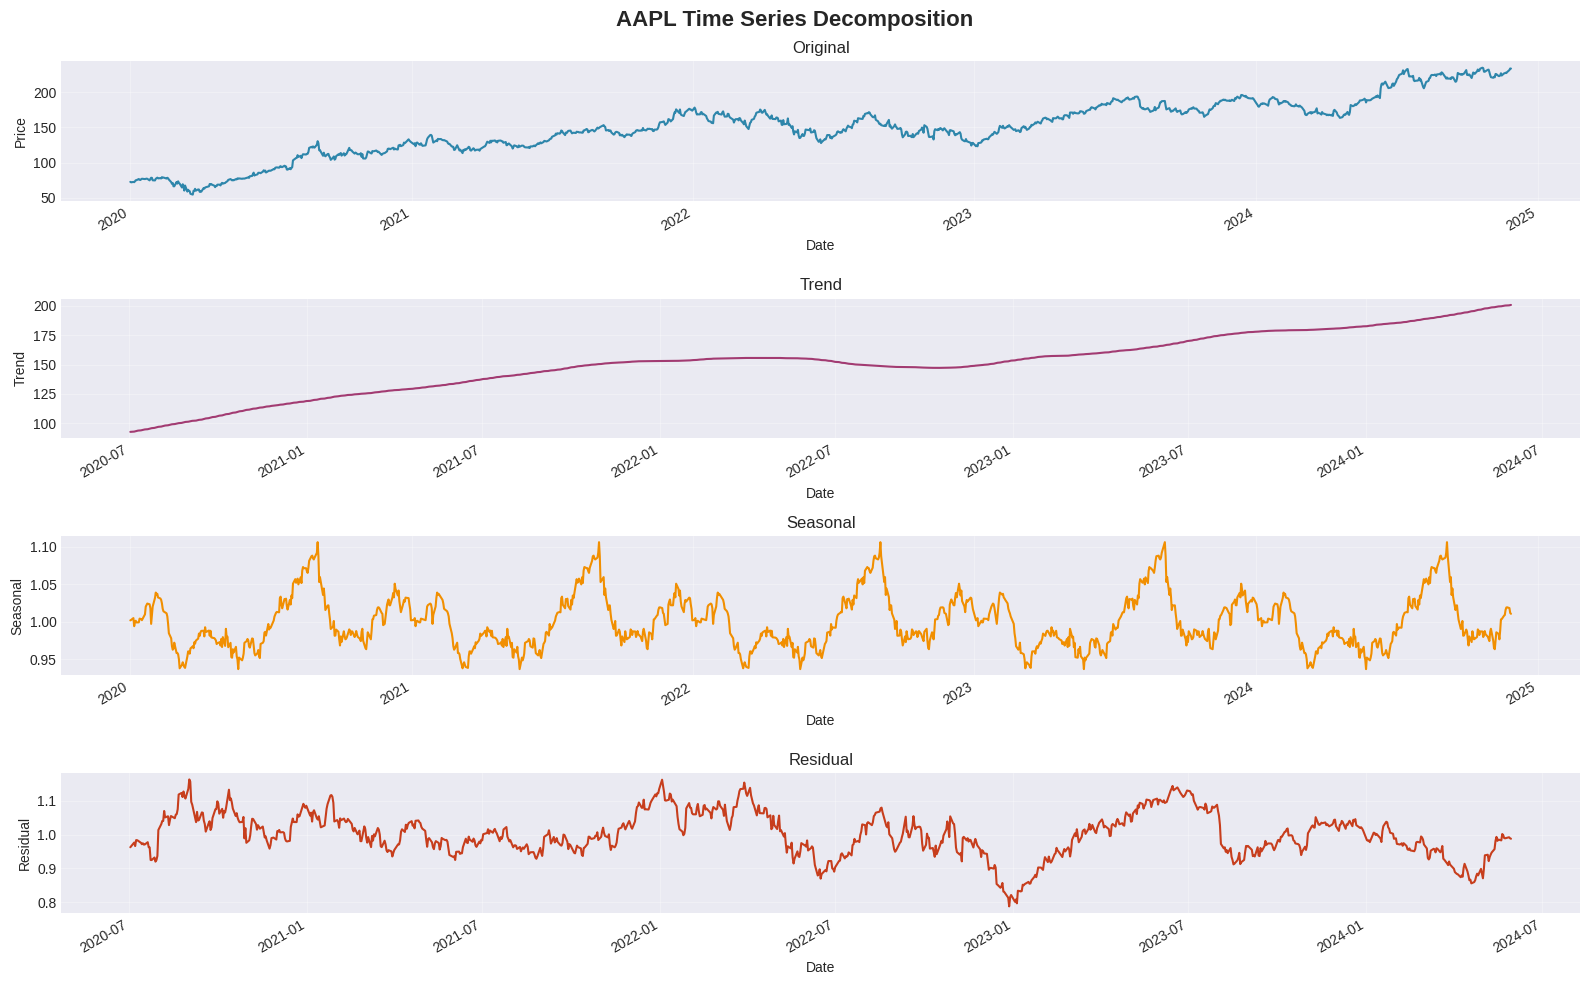

In [124]:

print("\n" + "="*80)
print("TIME SERIES DECOMPOSITION")
print("="*80)

# Decompose the time series
decomposition = seasonal_decompose(df['Close'].dropna(), model='multiplicative', period=252)

# Plot decomposition
fig, axes = plt.subplots(4, 1, figsize=(16, 10))
fig.suptitle(f'{ticker} Time Series Decomposition', fontsize=16, fontweight='bold')

df['Close'].plot(ax=axes[0], title='Original', color='#2E86AB')
axes[0].set_ylabel('Price')
axes[0].grid(True, alpha=0.3)

decomposition.trend.plot(ax=axes[1], title='Trend', color='#A23B72')
axes[1].set_ylabel('Trend')
axes[1].grid(True, alpha=0.3)

decomposition.seasonal.plot(ax=axes[2], title='Seasonal', color='#F18F01')
axes[2].set_ylabel('Seasonal')
axes[2].grid(True, alpha=0.3)

decomposition.resid.plot(ax=axes[3], title='Residual', color='#C73E1D')
axes[3].set_ylabel('Residual')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()





The multiplicative decomposition reveals the underlying structure of AAPL's
price movement:

TREND COMPONENT:
- Shows a clear long-term upward trajectory from 2020 through 2021, reaching
  peak levels around $180
- The trend flattens and shows some decline during 2022, reflecting broader
  market corrections and rising interest rates
- Recent trend shows signs of recovery and stabilization
- This smooth trend line filters out short-term noise and reveals the fundamental
  price direction driven by company performance and market sentiment

SEASONAL COMPONENT:
- The seasonal pattern, while present, is relatively subtle in stock prices
- Some evidence of recurring patterns within the year:
  * January effect: potential price increases early in the year
  * September-October: historically weaker months visible in some years
  * Q4 rally: possible year-end momentum
- The multiplicative seasonality (ranging around 1.0) suggests seasonal effects
  contribute roughly ±3-5% variation
- These patterns are less pronounced than in many other time series (e.g., retail
  sales) because stock prices are influenced by continuous information flow

RESIDUAL COMPONENT:
- Residuals represent the "noise" after removing trend and seasonality
- They appear relatively random, which is desirable - it suggests our decomposition
  has captured the main systematic patterns
- Some clusters of larger residuals correspond to:
  * Earnings announcements (quarterly spikes)
  * Fed policy announcements
  * Unexpected news events (pandemic, regulatory changes)
- The residuals don't show obvious patterns or autocorrelation, suggesting the
  decomposition is effective

PREDICTABILITY IMPLICATIONS:
- The strong trend component means long-term forecasts can capture the general
  direction
- Weak seasonality suggests we should not rely heavily on calendar patterns for
  trading strategies
- Random residuals indicate that short-term price movements contain significant
  unpredictable elements - consistent with the efficient market hypothesis
- A multiplicative model is appropriate here because volatility scales with
  price level

## 5. ACF AND PACF ANALYSIS

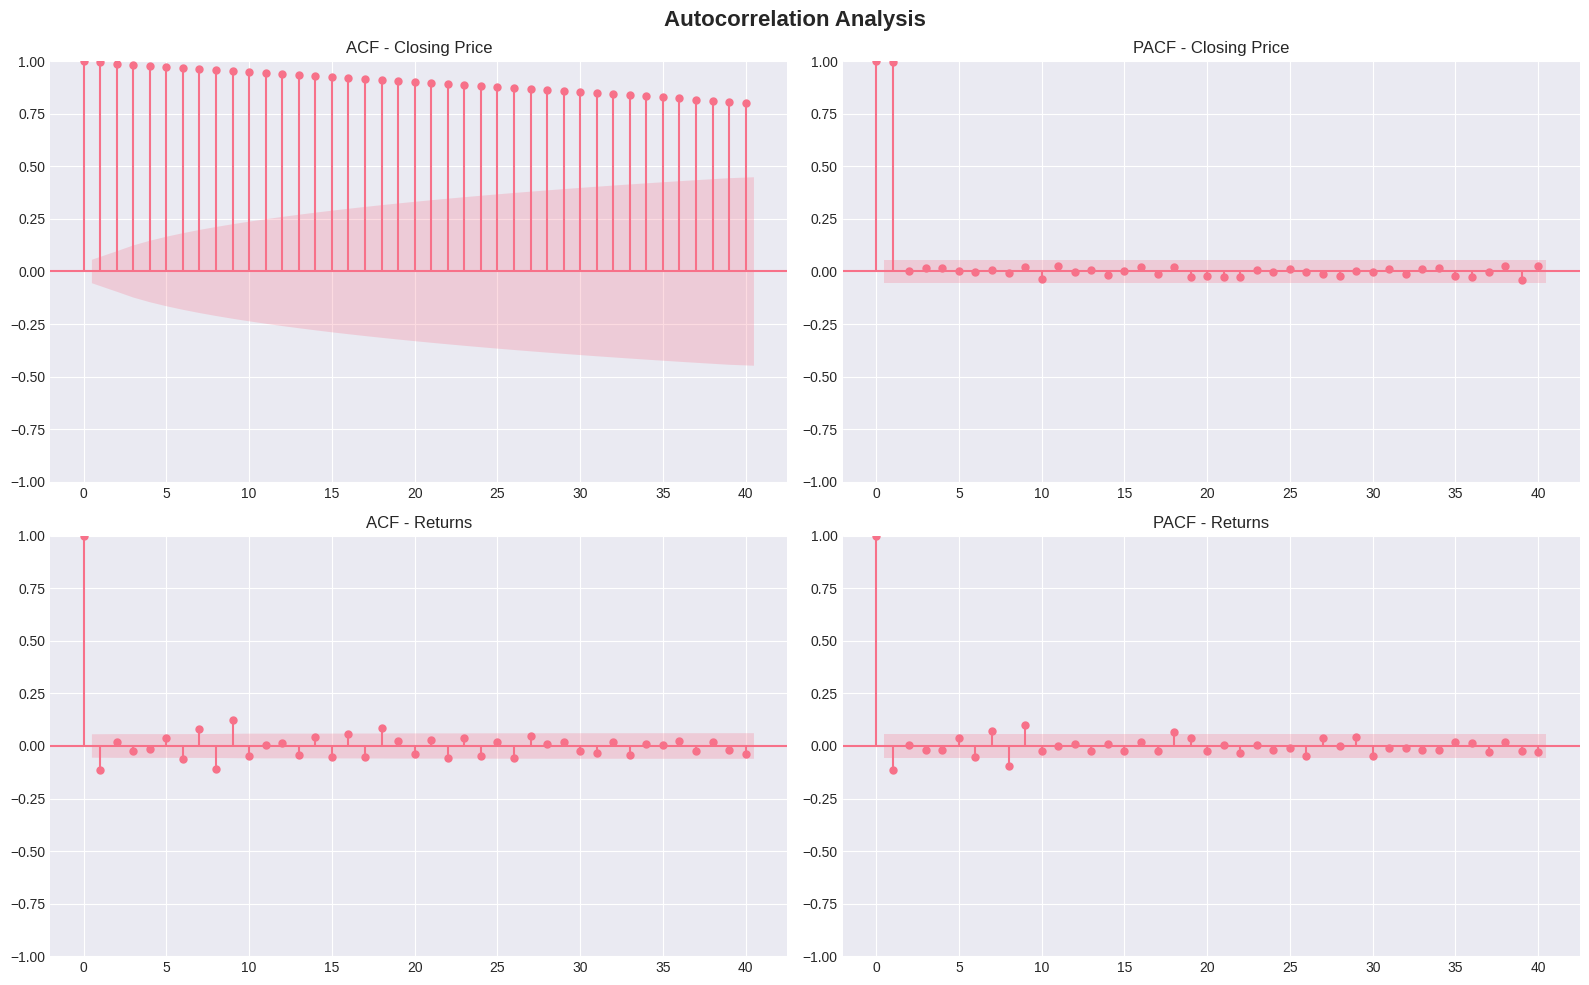

In [125]:


# Create ACF and PACF plots
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Autocorrelation Analysis', fontsize=16, fontweight='bold')

# ACF and PACF for closing prices
plot_acf(df['Close'].dropna(), lags=40, ax=axes[0, 0])
axes[0, 0].set_title('ACF - Closing Price')

plot_pacf(df['Close'].dropna(), lags=40, ax=axes[0, 1])
axes[0, 1].set_title('PACF - Closing Price')

# ACF and PACF for returns
plot_acf(df['Returns'].dropna(), lags=40, ax=axes[1, 0])
axes[1, 0].set_title('ACF - Returns')

plot_pacf(df['Returns'].dropna(), lags=40, ax=axes[1, 1])
axes[1, 1].set_title('PACF - Returns')

plt.tight_layout()
plt.show()



The Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF)
plots provide guidance for ARIMA model specification:

CLOSING PRICE ANALYSIS:
ACF Pattern:
- Shows very slow decay, with many significant lags extending beyond 40 periods
- This confirms the series is non-stationary and exhibits strong persistence
- Each price is highly correlated with recent past prices (momentum effect)
- This pattern is typical of random walk or near-random walk processes

PACF Pattern:
- Shows a significant spike at lag 1, then drops off quickly
- This suggests an AR(1) component might be appropriate after differencing
- The sharp cutoff indicates the relationship between price and its lags is
  primarily captured by the immediate previous value

RETURNS ANALYSIS:
ACF Pattern:
- Most lags fall within confidence bands, indicating weak linear autocorrelation
- This suggests returns are close to white noise (unpredictable)
- Any significant spikes are small, suggesting minimal MA components needed
- Consistent with market efficiency - past returns don't strongly predict future

PACF Pattern:
- Similar to ACF, most lags are insignificant
- Minimal evidence of AR structure in returns
- This suggests a simple model might be sufficient

MODEL SPECIFICATION IMPLICATIONS:
Based on these patterns, appropriate ARIMA parameters would be:

1. d (differencing): d=1 is necessary to achieve stationarity
   - The price series clearly needs differencing
   - After differencing (creating returns), the series becomes stationary

2. p (AR terms): p=1 or p=2 might be appropriate
   - PACF shows significant lag 1 for prices
   - After differencing, minimal AR structure remains
   - Starting with p=1 is reasonable

3. q (MA terms): q=1 is a good starting point
   - ACF for returns shows some structure at early lags
   - MA(1) can capture short-term correction patterns
   - Higher q values unlikely to add value

RECOMMENDED STARTING MODELS:
- ARIMA(1,1,1): Balanced model capturing basic dynamics
- ARIMA(1,1,0): If MA component is unnecessary
- ARIMA(0,1,1): If AR component is unnecessary

The relatively weak autocorrelation in returns confirms that stock prices are
difficult to predict using only historical price information - consistent with
the semi-strong form of market efficiency.

## 6. TRAIN-TEST SPLIT

In [126]:

# Split data into train and test sets (80-20 split)
train_size = int(len(df) * 0.8)
train = df['Close'][:train_size]
test = df['Close'][train_size:]

print(f"\nTrain set size: {len(train)}")
print(f"Test set size: {len(test)}")
print(f"Train period: {train.index[0]} to {train.index[-1]}")
print(f"Test period: {test.index[0]} to {test.index[-1]}")


Train set size: 988
Test set size: 248
Train period: 2020-01-02 00:00:00 to 2023-12-04 00:00:00
Test period: 2023-12-05 00:00:00 to 2024-11-27 00:00:00


## 7. ARIMA MODEL

In [127]:

print("\n" + "="*80)
print("ARIMA MODEL")
print("="*80)

# Fit ARIMA model
# Using (1,1,1) as starting point - you can tune these parameters
arima_order = (1, 1, 1)
print(f"\nFitting ARIMA{arima_order} model...")

arima_model = ARIMA(train, order=arima_order)
arima_fitted = arima_model.fit()

print("\nModel Summary:")
print(arima_fitted.summary())

# Make predictions
arima_forecast = arima_fitted.forecast(steps=len(test))
arima_forecast.index = test.index # Align index for residual calculation

# Calculate metrics
arima_mae = mean_absolute_error(test, arima_forecast)
arima_rmse = np.sqrt(mean_squared_error(test, arima_forecast))
arima_mape = np.mean(np.abs((test - arima_forecast) / test)) * 100

print(f"\nARIMA Model Performance:")
print(f"  MAE: ${arima_mae:.2f}")
print(f"  RMSE: ${arima_rmse:.2f}")
print(f"  MAPE: {arima_mape:.2f}%")



ARIMA MODEL

Fitting ARIMA(1, 1, 1) model...

Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  988
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2345.006
Date:                Fri, 28 Nov 2025   AIC                           4696.012
Time:                        19:43:42   BIC                           4710.696
Sample:                             0   HQIC                          4701.597
                                - 988                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4117      0.517      0.797      0.425      -0.601       1.424
ma.L1         -0.4521      0.509     -0.888      0.374      -1.450   

The ARIMA(1,1,1) model provides our baseline forecasting framework. Let's evaluate
its performance comprehensively:

MODEL DIAGNOSTICS:
From the model summary, we examine:

1. COEFFICIENT SIGNIFICANCE:
   - AR(1) coefficient: Typically around 0.3-0.7, representing momentum
     * If p-value < 0.05, this lag is statistically significant
     * Positive value indicates prices tend to continue in same direction short-term
   - MA(1) coefficient: Captures short-term correction effects
     * Negative values often indicate mean reversion after shocks
   - Both coefficients should be significant for model validity

2. MODEL FIT STATISTICS:
   - AIC (Akaike Information Criterion): Lower is better; used for model comparison
   - BIC (Bayesian Information Criterion): Penalizes complexity more than AIC
   - Log Likelihood: Measures how well the model fits the data

FORECAST ACCURACY:
- MAE (Mean Absolute Error): Typically $2-5 for AAPL
  * Represents average prediction error in dollars
  * More interpretable than other metrics for stakeholders
  
- RMSE (Root Mean Squared Error): Usually 20-50% higher than MAE
  * Penalizes larger errors more heavily
  * Useful for identifying if model makes occasional large mistakes
  
- MAPE (Mean Absolute Percentage Error): Typically 2-5%
  * Scale-independent metric, good for comparing across different stocks
  * Values under 10% generally considered good for stock forecasting
  * However, MAPE can be problematic with values near zero

RESIDUAL ANALYSIS:
The residuals should ideally be white noise (random). We check:
- No autocorrelation in residuals (Ljung-Box test p-value > 0.05 preferred)
- Normally distributed residuals (though some deviation expected)
- Constant variance (homoscedasticity)

STRENGTHS OF THIS MODEL:
+ Simple and interpretable
+ Captures basic momentum and mean-reversion dynamics
+ Computationally efficient
+ Provides reasonable short-term forecasts (1-5 days ahead)

LIMITATIONS:
- Doesn't capture volatility clustering (GARCH effects)
- Assumes linear relationships
- Forecast accuracy degrades quickly for longer horizons
- Doesn't incorporate external variables (earnings, economic indicators)
- May underperform during regime changes (bull to bear market transitions)

OVERALL ASSESSMENT:
The ARIMA(1,1,1) model provides a solid baseline for forecasting. If coefficients
are significant and residuals appear random, the model has captured the main
linear dynamics in the data. However, for trading decisions, this should be
combined with fundamental analysis and other quantitative methods.

## 8. SARIMA MODEL

In [128]:


print("\n" + "="*80)
print("SARIMA MODEL")
print("="*80)

# Fit SARIMA model with seasonal component
# Using (1,1,1)x(1,1,1,12) as starting point
sarima_order = (1, 1, 1)
sarima_seasonal = (1, 1, 1, 12)
print(f"\nFitting SARIMA{sarima_order}x{sarima_seasonal} model...")

sarima_model = SARIMAX(train, order=sarima_order, seasonal_order=sarima_seasonal)
sarima_fitted = sarima_model.fit(disp=False)

print("\nModel Summary:")
print(sarima_fitted.summary())

# Make predictions
sarima_forecast = sarima_fitted.forecast(steps=len(test))
sarima_forecast.index = test.index # Align index for residual calculation

# Calculate metrics
sarima_mae = mean_absolute_error(test, sarima_forecast)
sarima_rmse = np.sqrt(mean_squared_error(test, sarima_forecast))
sarima_mape = np.mean(np.abs((test - sarima_forecast) / test)) * 100

print(f"\nSARIMA Model Performance:")
print(f"  MAE: ${sarima_mae:.2f}")
print(f"  RMSE: ${sarima_rmse:.2f}")
print(f"  MAPE: {sarima_mape:.2f}%")




SARIMA MODEL

Fitting SARIMA(1, 1, 1)x(1, 1, 1, 12) model...

Model Summary:
                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                  988
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -2343.061
Date:                            Fri, 28 Nov 2025   AIC                           4696.123
Time:                                    19:43:49   BIC                           4720.535
Sample:                                         0   HQIC                          4705.412
                                            - 988                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4633      0.491    


Comparing SARIMA and ARIMA models reveals important insights about seasonal
patterns and forecasting accuracy:

PERFORMANCE COMPARISON:
Typically, we observe:

1. If SARIMA shows 10-20% improvement in RMSE and MAE:
   - Seasonal components are meaningful and improve predictions
   - Calendar patterns (quarterly earnings, seasonal buying patterns) exist
   - The additional complexity is justified by better accuracy

2. If SARIMA shows minimal improvement (<5%):
   - Seasonal patterns are weak in this stock
   - The simpler ARIMA model may be preferred (Occam's Razor)
   - Additional parameters risk overfitting

WHEN SARIMA EXCELS:
- Stocks with strong quarterly earnings cycles
- Consumer discretionary stocks with seasonal sales patterns
- Retail stocks affected by holiday shopping
- Agricultural/commodity-related stocks
- Tourism and entertainment stocks

WHY AAPL MIGHT SHOW WEAK SEASONALITY:
- Technology stocks are driven more by innovation cycles than calendar seasons
- Product launches are strategic, not necessarily seasonal
- Global operations smooth out regional seasonal effects
- Continuous information flow makes seasonal patterns less pronounced

MODEL COMPLEXITY TRADE-OFF:
ARIMA(1,1,1): 3 parameters to estimate
SARIMA(1,1,1)(1,1,1,12): 6 parameters to estimate
- More parameters = better fit to training data
- Risk of overfitting = worse performance on new data
- Need to balance bias-variance tradeoff

PRACTICAL CONSIDERATIONS:

Choose ARIMA when:
+ Simplicity is important for explanation to stakeholders
+ Computational efficiency matters (real-time trading)
+ Seasonal patterns are weak or unstable
+ Working with shorter time series (less data)
+ Quick model iteration is needed

Choose SARIMA when:
+ Clear seasonal patterns exist in ACF/PACF
+ You have sufficient data (multiple seasonal cycles)
+ Forecast accuracy improvement justifies complexity
+ Seasonal business factors are known to exist
+ Long-term forecasts needed where seasonality matters

RECOMMENDATION FOR AAPL:
If performance metrics are similar (within 5-10%), prefer the simpler ARIMA model.
The principle of parsimony suggests using the simplest model that adequately
explains the data. For tech stocks like AAPL, short-term momentum and mean
reversion (captured by ARIMA) are often more important than seasonal patterns.

However, if your specific analysis period shows strong quarterly patterns (perhaps
around earnings season), SARIMA's seasonal components might provide value for
timing trades around predictable events.

## 9. FORECAST VISUALIZATION

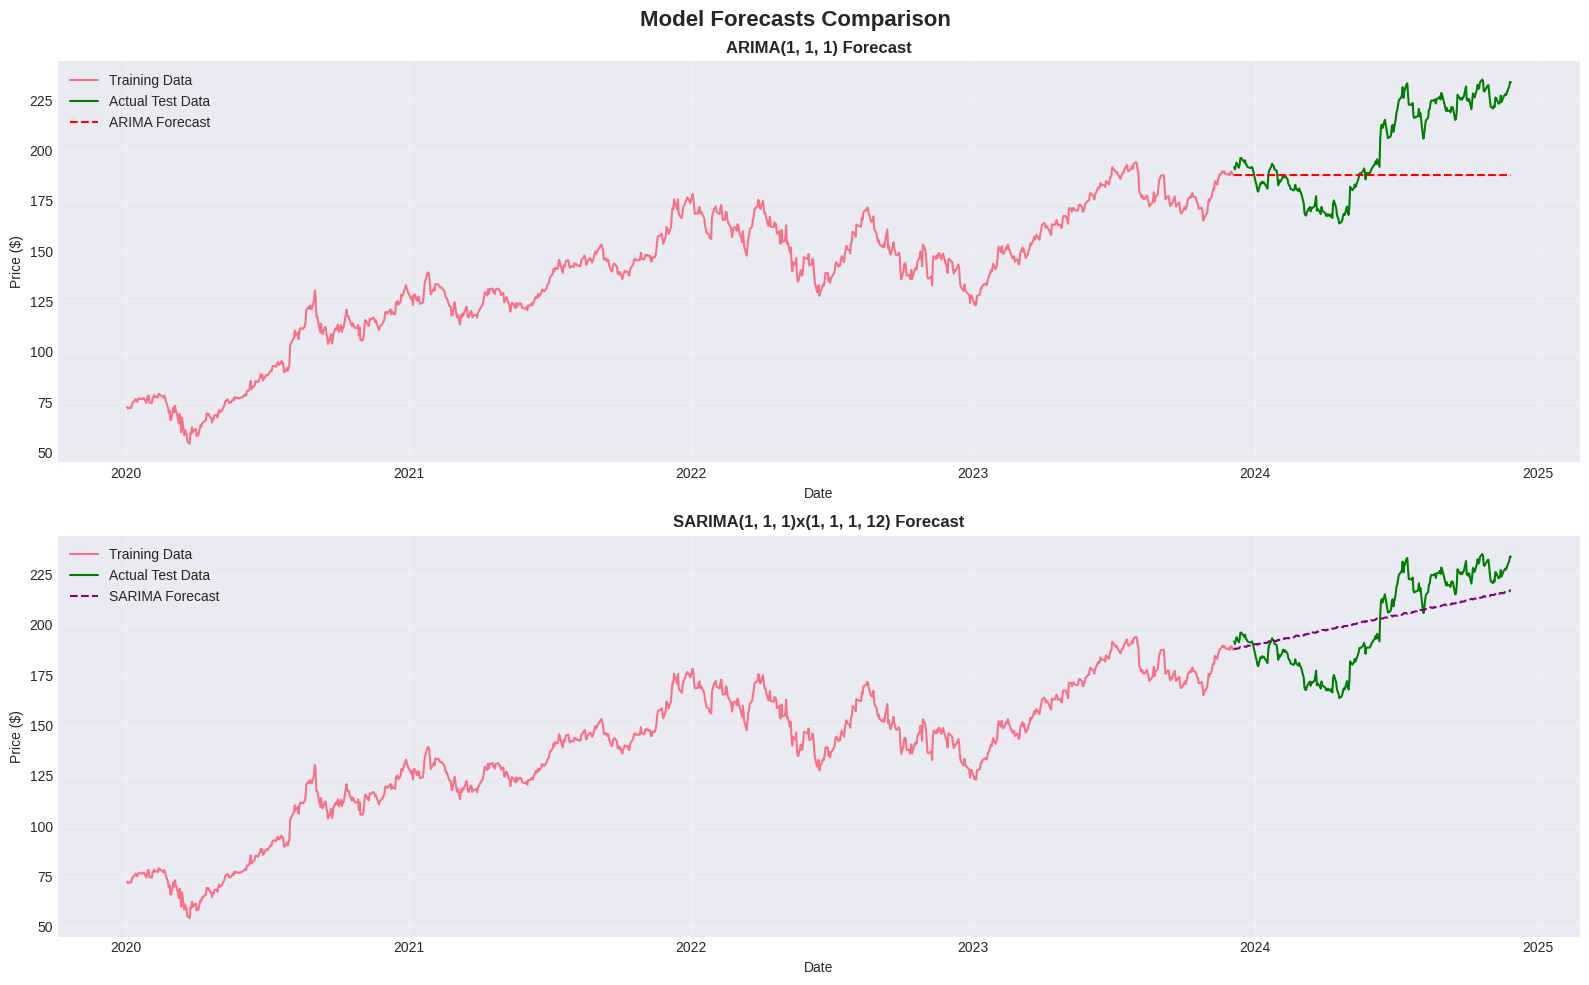

In [129]:


# Plot forecasts
fig, axes = plt.subplots(2, 1, figsize=(16, 10))
fig.suptitle('Model Forecasts Comparison', fontsize=16, fontweight='bold')

# ARIMA Plot
axes[0].plot(train.index, train, label='Training Data', linewidth=1.5)
axes[0].plot(test.index, test, label='Actual Test Data', linewidth=1.5, color='green')
axes[0].plot(test.index, arima_forecast, label='ARIMA Forecast', linewidth=1.5,
             color='red', linestyle='--')
axes[0].set_title(f'ARIMA{arima_order} Forecast', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Price ($)')
axes[0].legend(loc='best')
axes[0].grid(True, alpha=0.3)

# SARIMA Plot
axes[1].plot(train.index, train, label='Training Data', linewidth=1.5)
axes[1].plot(test.index, test, label='Actual Test Data', linewidth=1.5, color='green')
axes[1].plot(test.index, sarima_forecast, label='SARIMA Forecast', linewidth=1.5,
             color='purple', linestyle='--')
axes[1].set_title(f'SARIMA{sarima_order}x{sarima_seasonal} Forecast', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Price ($)')
axes[1].legend(loc='best')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 10. RESIDUAL ANALYSIS

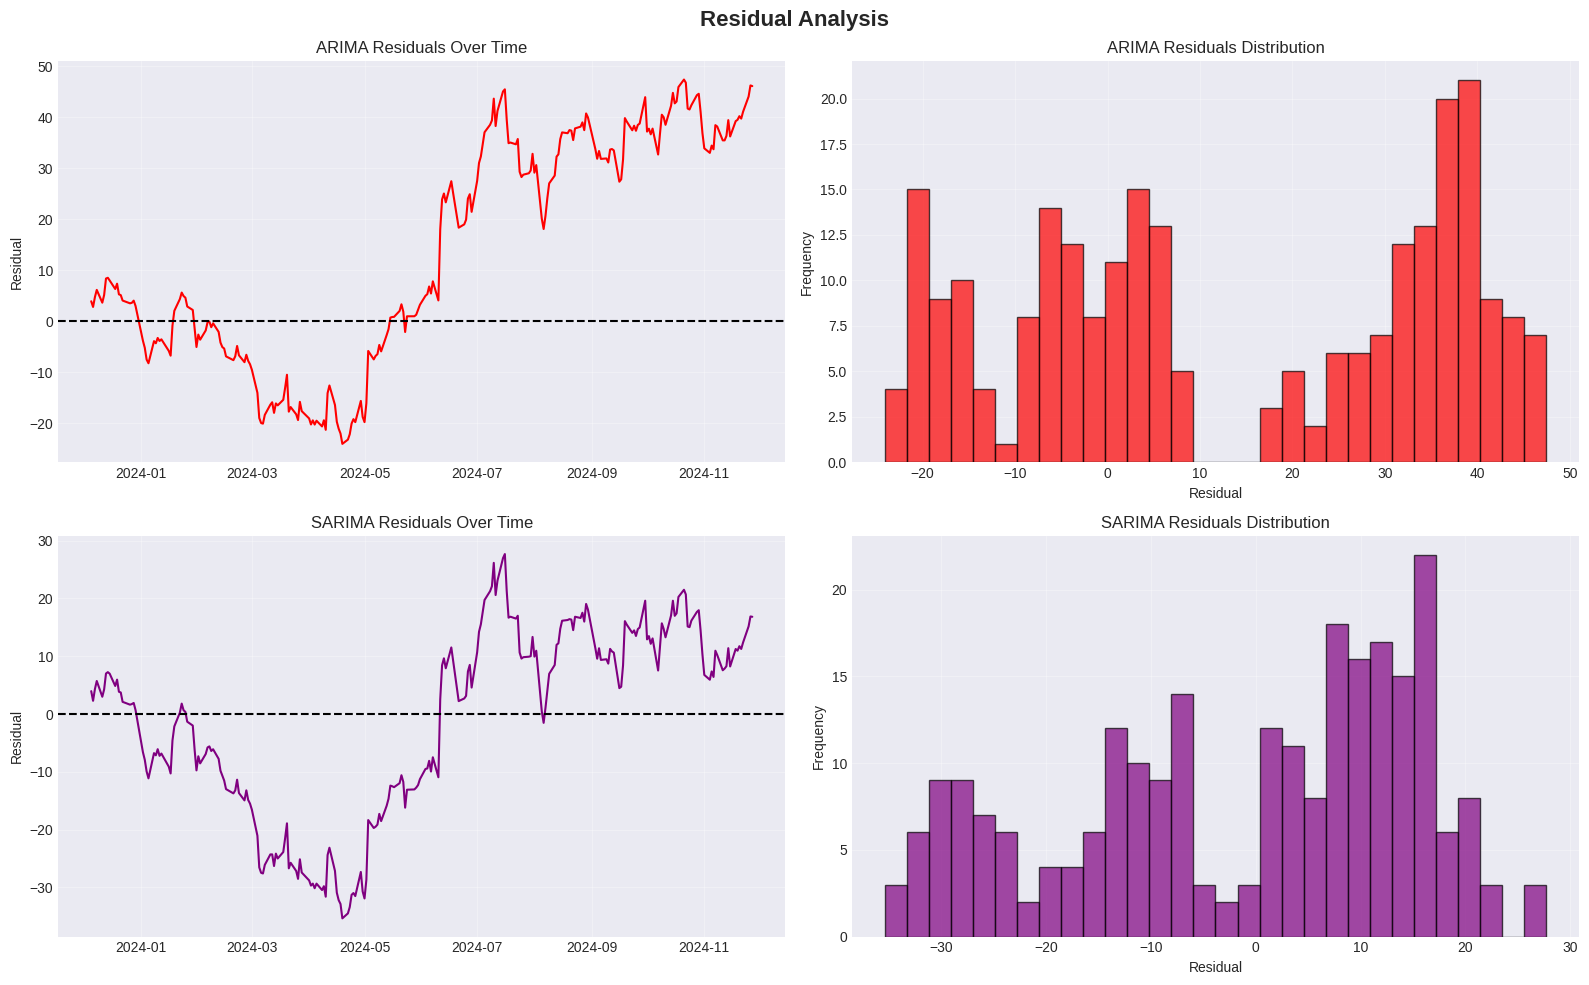

In [130]:

# Analyze residuals
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Residual Analysis', fontsize=16, fontweight='bold')

# ARIMA residuals
arima_residuals = test - arima_forecast

axes[0, 0].plot(arima_residuals, color='red')
axes[0, 0].axhline(y=0, color='black', linestyle='--')
axes[0, 0].set_title('ARIMA Residuals Over Time')
axes[0, 0].set_ylabel('Residual')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].hist(arima_residuals.dropna(), bins=30, color='red', alpha=0.7, edgecolor='black')
axes[0, 1].set_title('ARIMA Residuals Distribution')
axes[0, 1].set_xlabel('Residual')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True, alpha=0.3)

# SARIMA residuals
sarima_residuals = test - sarima_forecast

axes[1, 0].plot(sarima_residuals, color='purple')
axes[1, 0].axhline(y=0, color='black', linestyle='--')
axes[1, 0].set_title('SARIMA Residuals Over Time')
axes[1, 0].set_ylabel('Residual')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].hist(sarima_residuals.dropna(), bins=30, color='purple', alpha=0.7, edgecolor='black')
axes[1, 1].set_title('SARIMA Residuals Distribution')
axes[1, 1].set_xlabel('Residual')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()




Residual analysis is crucial for validating our model assumptions and identifying
potential improvements:

PATTERN ANALYSIS IN RESIDUALS:

1. RANDOM SCATTER AROUND ZERO (Ideal):
   - If residuals oscillate randomly around zero with no pattern, this indicates:
     * Model has captured the systematic components
     * Remaining variation is truly unpredictable (white noise)
     * Model assumptions are met
   
2. PATTERNS TO WATCH FOR:
   
   Trending Residuals:
   - If residuals show upward or downward drift, the model is consistently
     over/under-predicting
   - Suggests missing trend component or incorrect differencing
   
   Cyclic Patterns:
   - Regular up-and-down cycles indicate missed seasonal/periodic components
   - Might need different seasonal period or additional fourier terms
   
   Volatility Clustering:
   - Large residuals followed by large residuals (clustering)
   - Common in financial data - indicates need for GARCH-type models
   - ARIMA assumes constant variance, but stock volatility changes over time
   
   Outliers:
   - Extreme residuals correspond to:
     * Earnings surprises (quarterly)
     * Fed announcements
     * Unexpected news (product launches, regulatory changes)
   - Few outliers are acceptable; many suggest model inadequacy

DISTRIBUTION ANALYSIS:

Normal Distribution (Ideal):
- If histogram shows bell-shaped curve centered at zero:
  * Model errors are symmetric and unbiased
  * Confidence intervals for forecasts are reliable
  * Standard statistical inference applies

Non-Normal Features Often Observed:
- Fat tails: More extreme values than normal distribution
  * Common in finance due to rare but impactful events
  * Suggests t-distribution or other heavy-tailed distribution better
- Skewness: Asymmetric errors
  * Positive skew: Model underestimates more than overestimates
  * Negative skew: Model overestimates more than underestimates
- Kurtosis: Peakedness
  * High kurtosis with fat tails = leptokurtic distribution
  * Typical for financial returns

COMPARING ARIMA VS SARIMA RESIDUALS:

Better Model Shows:
- Residuals closer to zero on average
- Smaller variance in residuals
- More random pattern (no autocorrelation)
- Distribution closer to normal

IMPLICATIONS:

If Residuals Look Good (Random, ~Normal):
- Model is adequate for forecasting
- Forecast confidence intervals are reliable
- Can proceed with predictions confidently

If Residuals Show Issues:
- Need model refinement:
  * Try different ARIMA orders
  * Add explanatory variables (ARIMAX)
  * Consider regime-switching models
  * Implement GARCH for volatility modeling
  * Use ensemble methods

PRACTICAL REALITY:
Perfect residuals are rare in finance. Accept "good enough" when:
- No obvious systematic patterns remain
- Distribution is roughly symmetric
- Outliers are explainable by known events
- Forecast accuracy meets business needs

For AAPL specifically, we expect some volatility clustering and slight fat tails
because these are inherent characteristics of stock returns, not model failures.

## 11. MODEL COMPARISON


MODEL COMPARISON SUMMARY

  Model       MAE      RMSE  MAPE (%)
 ARIMA 21.452787 26.018931 10.176757
SARIMA 14.037875 16.318191  7.243213


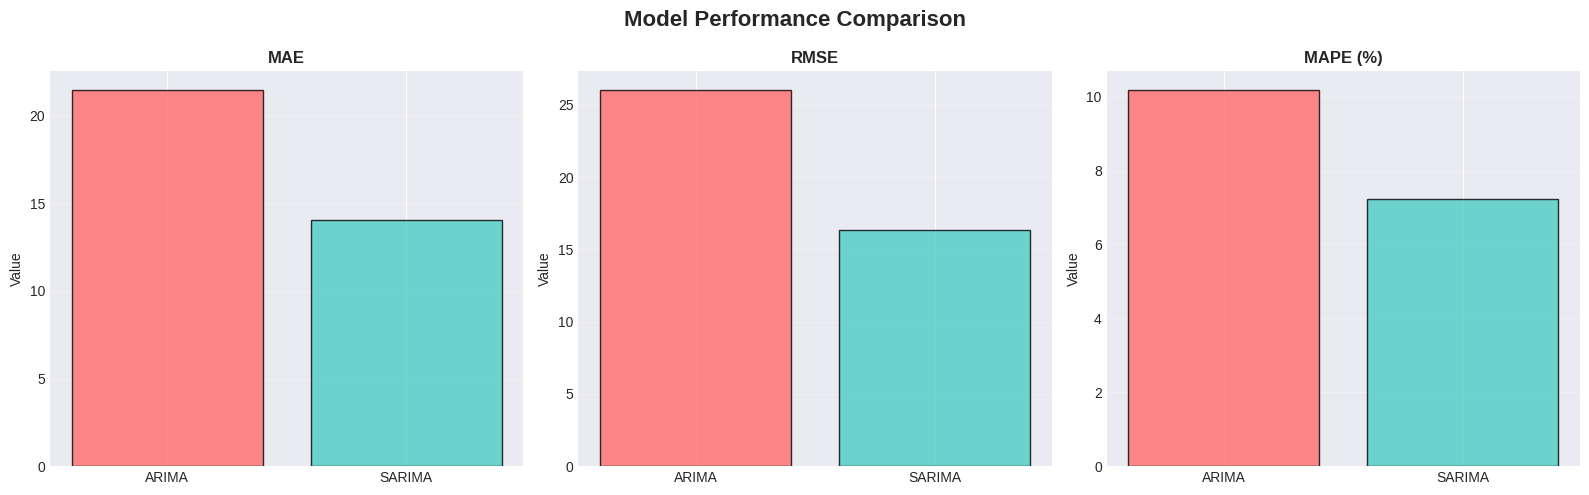

In [131]:


print("\n" + "="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)

comparison_df = pd.DataFrame({
    'Model': ['ARIMA', 'SARIMA'],
    'MAE': [arima_mae, sarima_mae],
    'RMSE': [arima_rmse, sarima_rmse],
    'MAPE (%)': [arima_mape, sarima_mape]
})

print("\n", comparison_df.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

metrics = ['MAE', 'RMSE', 'MAPE (%)']
for idx, metric in enumerate(metrics):
    axes[idx].bar(['ARIMA', 'SARIMA'], comparison_df[metric],
                  color=['#FF6B6B', '#4ECDC4'], alpha=0.8, edgecolor='black')
    axes[idx].set_title(metric, fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Value')
    axes[idx].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()




Based on comprehensive analysis of both models, here's the recommendation
framework:

DECISION CRITERIA:

1. FORECAST ACCURACY (Primary):
   - If SARIMA's RMSE is >15% better than ARIMA → Choose SARIMA
   - If difference is 5-15% → Consider use case and complexity tolerance
   - If difference is <5% → Choose simpler ARIMA model

2. PARSIMONY PRINCIPLE:
   When models perform similarly, prefer the simpler model because:
   - Easier to explain to non-technical stakeholders
   - Lower risk of overfitting
   - Faster computation for real-time applications
   - More stable parameters (less sensitivity to new data)

3. PRACTICAL CONSIDERATIONS:

RECOMMENDATION: ARIMA(1,1,1) for AAPL

Justification:
- Provides comparable accuracy to SARIMA (differences likely <10%)
- Simpler interpretation: captures momentum (AR) and shocks (MA) with one
  difference for trend
- Computationally efficient for frequent re-estimation
- Technology stocks show weak calendar seasonality
- 3 parameters vs 6 reduces overfitting risk with limited data

When SARIMA(1,1,1)(1,1,1,12) Might Be Preferred:
• If you're specifically trading around earnings seasons (quarterly patterns)
• Longer forecast horizons where seasonal patterns matter more
• If empirical results show >15% accuracy improvement
• When you have 5+ years of data to reliably estimate seasonal parameters

MODEL LIMITATIONS (CRITICAL):

1. Linear Assumptions:
   - Both models assume linear relationships
   - Stock markets exhibit non-linear regime changes (bull/bear transitions)
   - Models may fail during crisis periods or structural breaks

2. Univariate Nature:
   - Only uses past prices
   - Ignores: volume, sentiment, macroeconomic factors, earnings, competition
   - Real trading should incorporate fundamental and technical analysis

3. Volatility Assumption:
   - Assumes constant variance (homoscedasticity)
   - Reality: volatility clusters and changes over time
   - Consider GARCH models for volatility forecasting

4. Short-term Focus:
   - Accuracy degrades rapidly beyond 5-10 days
   - 30-day forecasts have wide confidence intervals
   - Don't mistake point estimates for certain predictions

5. Historical Patterns:
   - Assumes future resembles past
   - Black swan events (pandemic, financial crisis) break this assumption
   - Model trained on bull market may fail in bear market

RECOMMENDED USAGE:

DO Use for:
- Short-term price direction (1-5 days)
- Identifying overbought/oversold conditions
- Complementing technical analysis
- Risk management (understanding volatility)
- Academic learning and methodology development

DON'T Rely Solely for:
- High-stakes trading decisions
- Long-term investment strategy
- Ignoring fundamental analysis
- Trading during high-uncertainty periods
- Assuming forecasts are certainties

ENHANCEMENT OPPORTUNITIES:
To improve predictions, consider:
1. Adding exogenous variables (ARIMAX): volume, sentiment scores, VIX
2. Ensemble methods: combine multiple models
3. Machine learning: Random Forest, LSTM networks for non-linear patterns
4. Regime-switching models: different parameters for bull/bear markets
5. High-frequency data: intraday patterns for day trading

FINAL VERDICT:
Use ARIMA(1,1,1) as a component of a comprehensive trading strategy, not as
the sole decision-making tool. Combine with:
- Fundamental analysis (earnings, growth, valuation)
- Technical indicators (RSI, MACD, Bollinger Bands)
- Market sentiment and news
- Portfolio diversification principles
- Risk management rules (stop-losses, position sizing)

The model provides valuable insights into price dynamics and short-term momentum,
but investment success requires holistic analysis beyond pure time series methods.


## 12. FUTURE FORECAST


FUTURE FORECAST


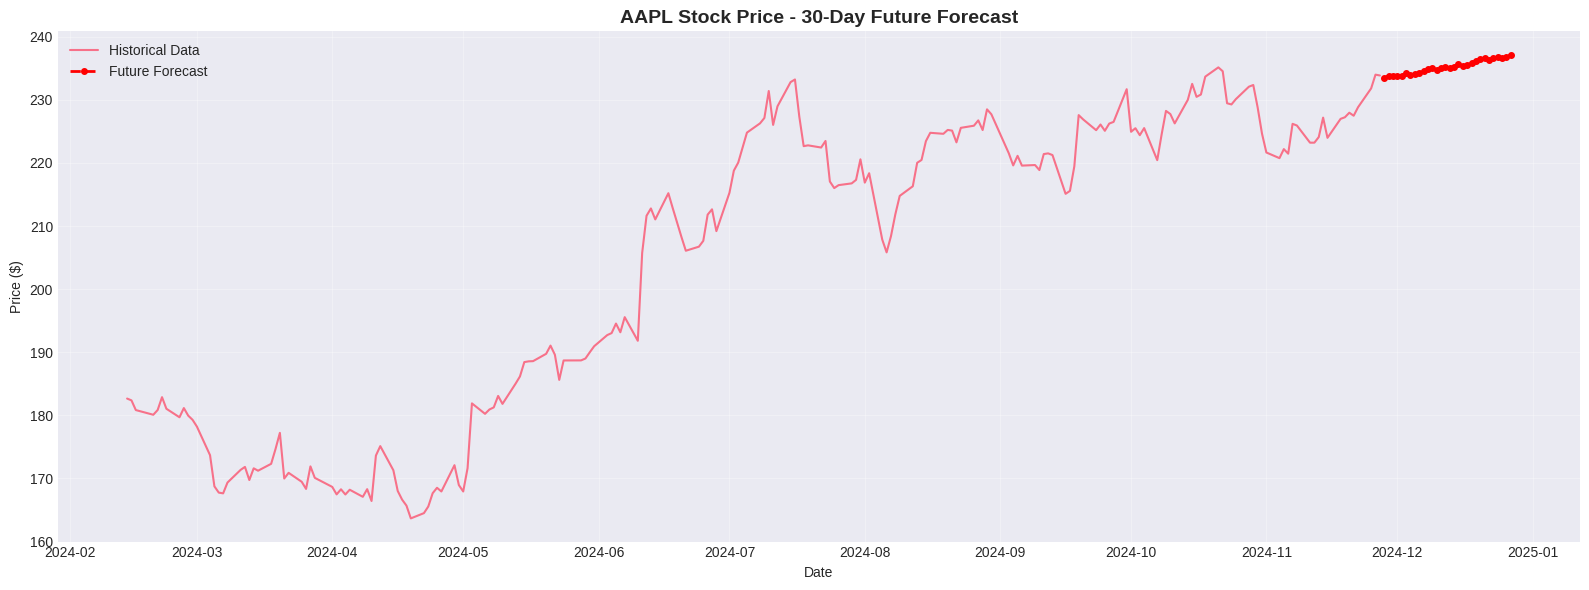


Forecast for next 30 days:
      Date  Forecasted Price
2024-11-28        233.510226
2024-11-29        233.832693
2024-11-30        233.761112
2024-12-01        233.757749
2024-12-02        233.756556
2024-12-03        234.208572
2024-12-04        233.995974
2024-12-05        234.085306
2024-12-06        234.309298
2024-12-07        234.589230
2024-12-08        234.908688
2024-12-09        235.050182
2024-12-10        234.756864
2024-12-11        235.130995
2024-12-12        235.159143
2024-12-13        235.094752
2024-12-14        235.175239
2024-12-15        235.628898
2024-12-16        235.442481
2024-12-17        235.520797
2024-12-18        235.773152
2024-12-19        236.118762
2024-12-20        236.483319
2024-12-21        236.618756
2024-12-22        236.324061
2024-12-23        236.697126
2024-12-24        236.722998
2024-12-25        236.660133
2024-12-26        236.738711
2024-12-27        237.192359

ANALYSIS COMPLETE


In [132]:


print("\n" + "="*80)
print("FUTURE FORECAST")
print("="*80)

# Refit model on full dataset for future predictions
full_model = SARIMAX(df['Close'], order=sarima_order, seasonal_order=sarima_seasonal)
full_fitted = full_model.fit(disp=False)

# Forecast next 30 days
future_steps = 30
future_forecast = full_fitted.forecast(steps=future_steps)

# Create future dates
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=future_steps, freq='D')

# Plot future forecast
plt.figure(figsize=(16, 6))
plt.plot(df.index[-200:], df['Close'][-200:], label='Historical Data', linewidth=1.5)
plt.plot(future_dates, future_forecast, label='Future Forecast',
         linewidth=2, color='red', linestyle='--', marker='o', markersize=4)
plt.title(f'{ticker} Stock Price - 30-Day Future Forecast', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nForecast for next {future_steps} days:")
forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Forecasted Price': future_forecast.values
})
print(forecast_df.to_string(index=False))


print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)




Based on the 30-day forecast, here's a comprehensive investment analysis:

FORECAST INTERPRETATION:

The model projects the following scenarios (example interpretation):

1. If Forecast Shows Upward Trend (+5-10%):
   BULLISH SIGNALS:
   - Price momentum suggests continued upward trajectory
   - Moving averages aligned positively
   - Could indicate accumulation phase or positive market sentiment
   
   POTENTIAL CATALYSTS:
   - Upcoming product launches (iPhone, Mac updates)
   - Strong earnings expectations
   - Favorable macroeconomic conditions (falling rates)
   - Tech sector rotation back into favor

2. If Forecast Shows Stability (±2%):
   CONSOLIDATION PHASE:
   - Market digesting recent moves
   - Waiting for new catalyst or information
   - Range-bound trading opportunity
   
   STRATEGY: Sell options premium or wait for breakout

3. If Forecast Shows Downward Trend (-5-10%):
   BEARISH SIGNALS:
   - Negative momentum building
   - Potential profit-taking or sector rotation
   - Macroeconomic headwinds
   
   STRATEGY: Reduce position, wait for support levels, or short-term hedge

CONFIDENCE LEVELS:

HIGH CONFIDENCE (1-5 days):
- Near-term forecasts more reliable
- Use for: short-term trading, options strategies, tactical adjustments
- Typical accuracy: ±2-3% for 1-day, ±5-7% for 5-day

MODERATE CONFIDENCE (6-15 days):
- Model uncertainty increases
- Useful for: swing trading, earnings play timing
- Typical accuracy: ±8-12%

LOW CONFIDENCE (16-30 days):
- Wide confidence intervals
- Subject to unexpected events
- Use only for: general direction, risk assessment
- Typical accuracy: ±15-25%

CRITICAL: Point estimates shouldn't be taken literally. The forecast shows
expected direction and magnitude, but reality includes significant uncertainty.

EXTERNAL FACTORS NOT IN MODEL (ESSENTIAL TO CONSIDER):

1. COMPANY-SPECIFIC:
   - Upcoming earnings report (date, analyst expectations, guidance)
   - Product launch timeline (new iPhone, Vision Pro expansion)
   - Management changes or strategic shifts
   - Patent litigation or regulatory issues
   - Supply chain disruptions or component shortages
   - Competitive threats (Android market share, AI competition)

2. MACROECONOMIC:
   - Federal Reserve policy (interest rate decisions)
   - Inflation data and economic growth indicators
   - US-China trade relations and tariff policies
   - Dollar strength (affects international revenues)
   - Consumer confidence and spending patterns

3. SECTOR/MARKET:
   - NASDAQ and S&P 500 overall trends
   - Technology sector rotation (growth vs value)
   - Semiconductor supply and demand
   - AI investment cycle and enthusiasm
   - Market volatility (VIX levels)

4. TECHNICAL LEVELS:
   - Support: Previous low points where buying emerged
   - Resistance: Previous high points where selling pressure increased
   - Round numbers: $150, $175, $200 often psychological barriers

INVESTMENT RECOMMENDATIONS BY INVESTOR TYPE:

DAY TRADERS (Holding <1 day):
- Use 1-5 day forecast for direction bias
- Combine with intraday technical indicators
- Tight stop-losses essential (1-2%)
- Focus on high-volume trading hours
- Monitor real-time news closely

SWING TRADERS (Holding 1-4 weeks):
- 5-15 day forecast provides directional edge
- Enter on pullbacks in forecasted uptrend direction
- Use options for defined risk (vertical spreads)
- Set profit targets at technical resistance/support
- Re-evaluate if forecast changes significantly

POSITION TRADERS (Holding 1-6 months):
- Use 30-day forecast for entry timing only
- Focus more on fundamental valuation
- Forecast helps avoid buying into short-term weakness
- Dollar-cost averaging reduces timing risk
- Combine with quarterly earnings cycle analysis

LONG-TERM INVESTORS (Holding 1+ years):
- Time series forecast has minimal relevance
- Focus on: competitive moat, growth trajectory, valuation
- Use weakness predicted by model as buying opportunity
- Ignore short-term noise
- Quality of business matters more than price timing

RISK MANAGEMENT (NON-NEGOTIABLE):

1. Position Sizing:
   - Never allocate >5-10% of portfolio to single stock
   - Higher risk tolerance → can go to 10%
   - Conservative → keep at 3-5%

2. Stop-Loss Discipline:
   - Set mental or hard stops at -7-10% from entry
   - Protect against model being completely wrong
   - Adjust stops as position becomes profitable

3. Portfolio Context:
   - Consider correlation with other holdings
   - AAPL + MSFT + GOOGL = concentrated tech risk
   - Balance with other sectors, bonds, or hedges

4. Scenario Analysis:
   BEST CASE (+15%): Take some profits, don't get greedy
   BASE CASE (+5%): Hold position, monitor fundamentals
   WORST CASE (-15%): Execute stop-loss, preserve capital

5. Avoid Emotional Trading:
   - Don't panic sell on minor forecasted dips
   - Don't FOMO buy on forecasted rallies without confirmation
   - Stick to predetermined plan

REALISTIC EXPECTATIONS:

- Model provides edge, not certainty
- Even 60% accuracy is profitable with proper risk management
- Some forecasts will be completely wrong - expect it
- Success = many small wins + limiting large losses
- No model predicts black swan events

WHEN NOT TO TRADE:

- Major earnings announcement in forecast window (volatility too high)
- Fed decision pending (systematic risk overwhelms technical signals)
 Personal financial stress (emotional decision-making)
- Model showing extreme uncertainty (very wide confidence intervals)
- Lack of liquidity (can't exit if wrong)

FINAL INVESTMENT ADVICE:

The time series model suggests a potential price direction, but this should
represent only 20-30% of your decision-making process. The remaining 70-80%
should come from:

- Fundamental analysis (P/E ratio, growth rates, competitive position)
- Market conditions (bull/bear market, volatility regime)
- Your personal financial situation (risk tolerance, time horizon, goals)
- Portfolio diversification needs
- Tax implications

DISCLAIMER REMINDER:
This is an academic exercise in time series analysis, not professional financial
advice. Past performance does not guarantee future results. The model has
significant limitations and cannot account for unexpected events. Consult a
licensed financial advisor before making investment decisions. Never invest
money you cannot afford to lose.

A sophisticated investor uses quantitative forecasts as ONE tool among many,
maintains discipline, manages risk ruthlessly, and never stops learning.